## Notebook for testing Data Assimilation on modern climate data
### Aim: testing how the structure of seasonal result depends on the method of assimilation

Author: **N.J. de Winter** (*n.j.de.winter@vu.nl*)<br>
Assitant Professor Vrije Universiteit Amsterdam

In [13]:
# Load packages
import numpy as np # The 'numpy' package is needed for matrix operations and calculations
import pandas as pd # The 'pandas' package helps us to import and manage data
import math as math # Math package for data cleaning
from scipy import stats # Import scipy.stats package for confidence intervals
# # ---TO DO: Install D47calib and use here--- https://github.com/mdaeron/D47calib
# # import D47calib as D47c # Import the package for treating clumped isotope data by Daëron and Vermeesch (2023)
import matplotlib.pyplot as plt # The 'matplotlib' package contains tools needed to plot our data and results
%matplotlib inline

# First test how aligning data by the warmest day of the year affects seasonal structure

### Load KNMI data

In [2]:
# Load KNMI data for weather station De Kooy (Den Helder)
# Data soure: https://www.knmi.nl/nederland-nu/klimatologie/daggegevens
DeKooy_data = pd.read_csv('KNMI data/KNMI_DeKooy_190601012_20141214.csv') # Load the data for this assignment into Python and in the Jupyter environment.
DeKooy_data.head()

,STN,YYYYMMDD,DDVEC,FHVEC,FG,FHX,FHXH,FHN,FHNH,FXX,...,VVNH,VVX,VVXH,NG,UG,UX,UXH,UN,UNH,EV24
0,235,19060101,113.0,67.0,67.0,87.0,12.0,51.0,1.0,NaN,...,NaN,NaN,NaN,NaN,76.0,NaN,NaN,NaN,NaN,NaN
1,235,19060102,113.0,62.0,62.0,77.0,5.0,51.0,19.0,NaN,...,NaN,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN
2,235,19060103,122.0,36.0,36.0,62.0,2.0,21.0,15.0,NaN,...,NaN,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN
3,235,19060104,181.0,41.0,41.0,98.0,22.0,21.0,5.0,NaN,...,NaN,NaN,NaN,NaN,98.0,NaN,NaN,NaN,NaN,NaN
4,235,19060105,244.0,36.0,41.0,57.0,4.0,26.0,3.0,NaN,...,NaN,NaN,NaN,NaN,96.0,NaN,NaN,NaN,NaN,NaN


### Separate days, months and years and isolate relevant data

In [3]:
# Convert dates to days, months and years
DeKooy_data['YYYYMMDD'] = pd.to_datetime(DeKooy_data['YYYYMMDD'], format='%Y%m%d')  # Convert YYYYMMDD to datetime
DeKooy_data['year'] = DeKooy_data['YYYYMMDD'].dt.year  # Extract year
DeKooy_data['month'] = DeKooy_data['YYYYMMDD'].dt.month  # Extract month
DeKooy_data['day'] = DeKooy_data['YYYYMMDD'].dt.day  # Extract day

# Isolate the columns containing temperature data and the new date-related columns
DeKooy_data_filtered = DeKooy_data[['year', 'month', 'day', 'TG', 'TN', 'TX']].copy() # TG = average daily T, TN = max daily T and TX = min daily T
DeKooy_data_filtered[['TG', 'TN', 'TX']] = DeKooy_data_filtered[['TG', 'TN', 'TX']] / 10 # Divide temperature values by 10 because they are given in 0.1 degrees C units
DeKooy_data_filtered['T_sd'] = DeKooy_data_filtered['TX'] - DeKooy_data_filtered['TN'] # Define temperature uncertainty from daily minimum and maximum

# View the resulting DataFrame
print(DeKooy_data_filtered.head())

   year  month  day   TG   TN   TX  T_sd
0  1906      1    1 -2.8 -4.5 -1.3   3.2
1  1906      1    2 -2.5 -3.8 -1.0   2.8
2  1906      1    3 -1.2 -4.6  3.7   8.3
3  1906      1    4  5.6  3.5  7.2   3.7
4  1906      1    5  6.0  4.9  7.7   2.8


### Function to anchor the warmest day to August 15 (simulating the alignment that happens with shell data)

In [4]:
# Create function that takes a dataframe with columns 'year', 'month', 'day', and a temperature column specified by the user,
# identifies the warmest day in each year and anchors that day to the specified date (default: August 15)
def shift_dates_to_anchor(df, temp_col, target_day = 15, target_month = 8):
    """
    Shifts dates so the maximum temperature day (from the specified column) aligns with the specified day and month,
    and adjusts all other dates relative to this anchor, handling overflow.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing 'year', 'month', 'day', and a temperature column.
        temp_col (str): Name of the column containing temperature values.
        target_day (int): Day of the month to which to shift the warmest day.
        target_month (int): Number of month to which to shift the warmest day.

    Returns:
        pd.DataFrame: DataFrame with shifted dates.
    """
    # Create an empty list to store the shifted data
    shifted_data = []

    # Loop through each year
    for year in df['year'].unique():
        # Subset the data for the current year
        year_data = df[df['year'] == year].copy()

        # Find the date of the maximum temperature
        max_temp_row = year_data.loc[year_data[temp_col].idxmax()]
        max_date = pd.Timestamp(year, int(max_temp_row['month']), int(max_temp_row['day']))

        # Define the anchor date (August 15 of the same year)
        anchor_date = pd.Timestamp(year, target_month, target_day)

        # Calculate the difference (in days) between the max temp date and the anchor date
        shift_days = (max_date - anchor_date).days

        # Shift all dates by the negative of this difference
        year_data['original_date'] = pd.to_datetime(year_data[['year', 'month', 'day']])
        year_data['shifted_date'] = year_data['original_date'] - pd.to_timedelta(shift_days, unit='D')

        # Handle overflow (dates before January 1 or after December 31)
        year_data['shifted_date'] = year_data['shifted_date'].apply(
            lambda d: d if d.year == year else (
                pd.Timestamp(year, 1, 1) + (d - pd.Timestamp(d.year, 1, 1))
                if d.year < year else pd.Timestamp(year, 1, 1) + (d - pd.Timestamp(d.year, 1, 1))
            )
        )

        # Update year, month, and day to match the shifted date
        year_data['year'] = year_data['shifted_date'].dt.year
        year_data['month'] = year_data['shifted_date'].dt.month
        year_data['day'] = year_data['shifted_date'].dt.day
        year_data['shift_days'] = shift_days # Keep track of the number and direction of days in the shift for this year

        # Append the processed data to the list
        shifted_data.append(year_data)

    # Combine all shifted data back into a single DataFrame
    shifted_df = pd.concat(shifted_data, ignore_index = True)
    return shifted_df

### Apply the function on KNMI data

In [5]:
# Apply the function
DeKooy_data_shifted = shift_dates_to_anchor(DeKooy_data_filtered, "TG", 15, 8)

# View the shifted DataFrame
print(DeKooy_data_shifted)

       year  month  day   TG   TN   TX  T_sd original_date shifted_date  \
0      1906      1   16 -2.8 -4.5 -1.3   3.2    1906-01-01   1906-01-16   
1      1906      1   17 -2.5 -3.8 -1.0   2.8    1906-01-02   1906-01-17   
2      1906      1   18 -1.2 -4.6  3.7   8.3    1906-01-03   1906-01-18   
3      1906      1   19  5.6  3.5  7.2   3.7    1906-01-04   1906-01-19   
4      1906      1   20  6.0  4.9  7.7   2.8    1906-01-05   1906-01-20   
...     ...    ...  ...  ...  ...  ...   ...           ...          ...   
43443  2024      1    6  4.9  4.0  5.6   1.6    2024-12-10   2024-01-06   
43444  2024      1    7  4.8  4.0  6.5   2.5    2024-12-11   2024-01-07   
43445  2024      1    8  5.9  3.8  7.9   4.1    2024-12-12   2024-01-08   
43446  2024      1    9  2.2  0.3  3.9   3.6    2024-12-13   2024-01-09   
43447  2024      1   10  6.1  1.3  8.2   6.9    2024-12-14   2024-01-10   

       shift_days  
0             -15  
1             -15  
2             -15  
3             -15  

### Plot monthly distribution of shifted vs unshifted data

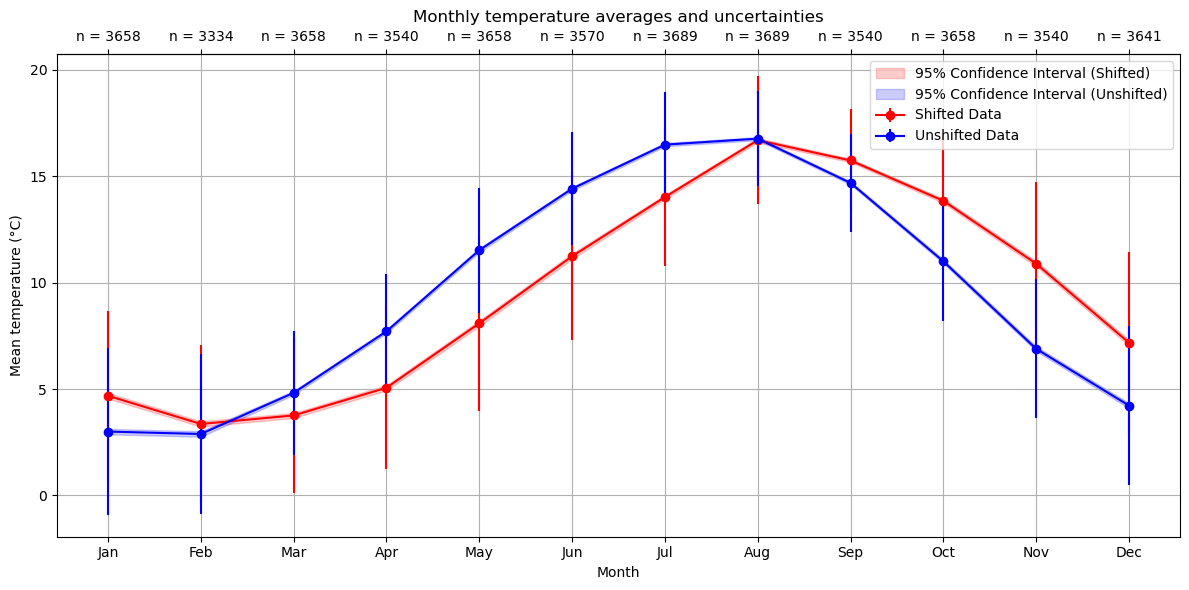

In [18]:
# Add 'month' column for shifted and unshifted data
DeKooy_data_shifted['shifted_month'] = pd.to_datetime(DeKooy_data_shifted["shifted_date"]).dt.month
DeKooy_data_shifted['unshifted_month'] = pd.to_datetime(DeKooy_data_shifted["original_date"]).dt.month

# Compute mean and standard deviation for shifted data
shifted_stats = DeKooy_data_shifted.groupby('shifted_month')["TG"].agg(['mean', 'std', 'count']).reset_index()
shifted_stats.rename(columns = {'mean': 'shifted_mean', 'std': 'shifted_std', 'count': 'shifted_N'}, inplace = True)

# Compute mean and standard deviation for unshifted data
unshifted_stats = DeKooy_data_shifted.groupby('unshifted_month')["TG"].agg(['mean', 'std', 'count']).reset_index()
unshifted_stats.rename(columns = {'mean': 'unshifted_mean', 'std': 'unshifted_std', 'count': 'unshifted_N'}, inplace = True)

# Merge statistics for easier plotting
monthly_stats = pd.merge(shifted_stats, unshifted_stats, left_on = 'shifted_month', right_on = 'unshifted_month')

# Plot the data
plt.figure(figsize = (12, 6))

# Plot shifted data
plt.errorbar(
    monthly_stats['shifted_month'], 
    monthly_stats['shifted_mean'], 
    yerr = monthly_stats['shifted_std'], 
    fmt = '-o',
    label = 'Shifted Data',
    color = 'red'
)
# Add 95% confidence intervals for the shifted data (mean ± 1.96 * std deviation)
plt.fill_between(monthly_stats['shifted_month'],
    monthly_stats['shifted_mean'] - stats.t.ppf(1 - 0.025, monthly_stats['shifted_N']) * monthly_stats['shifted_std'] / np.sqrt(monthly_stats['shifted_N']),
    monthly_stats['shifted_mean'] + stats.t.ppf(1 - 0.025, monthly_stats['shifted_N']) * monthly_stats['shifted_std'] / np.sqrt(monthly_stats['shifted_N']), 
    color = 'red',
    alpha = 0.2,
    label = '95% Confidence Interval (Shifted)'
)
# Plot unshifted data
plt.errorbar(
    monthly_stats['unshifted_month'], 
    monthly_stats['unshifted_mean'], 
    yerr = monthly_stats['unshifted_std'], 
    fmt = '-o', label = 'Unshifted Data', color = 'blue'
)
# Add 95% confidence intervals for the unshifted data (mean ± 1.96 * std deviation)
plt.fill_between(monthly_stats['unshifted_month'],
    monthly_stats['unshifted_mean'] - stats.t.ppf(1 - 0.025, monthly_stats['unshifted_N']) * monthly_stats['unshifted_std'] / np.sqrt(monthly_stats['unshifted_N']),
    monthly_stats['unshifted_mean'] + stats.t.ppf(1 - 0.025, monthly_stats['unshifted_N']) * monthly_stats['unshifted_std'] / np.sqrt(monthly_stats['unshifted_N']), 
    color = 'blue',
    alpha = 0.2,
    label = '95% Confidence Interval (Unshifted)'
)

# Add numbers of daily datapoints to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(monthly_stats['unshifted_month'])
secax.set_xticklabels([f"n = {int(n)}" for n in monthly_stats['unshifted_N']])
secax.tick_params(axis = 'x', rotation = 0)

# Add labels, legend, and grid
plt.xticks(ticks = range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.xlabel('Month')
plt.ylabel(f'Mean temperature (°C)')
plt.title(f'Monthly temperature averages, spread and uncertainties for KNMI data from weather station De Kooy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
